In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
testing_length = 40

full_angle_recon = np.load('full_angle_TV_0.25_exp_t12800.npy')[-testing_length:, -1, 0, 25:-29, 25:-29].astype(np.float32)

offset = 50
TV_weight = 2

FBP = []
iterative_sparse_recon = []
iterative_sparse_TV_recon = []

for photon in tqdm(['exp0035_t50', 'exp0048_t80', 'exp0075_t128', 'exp0.135_t200', 'exp0.21_t320', 'exp0.35_t500', 'exp0.55_t800', 'exp0.88_t1280', 'exp1.45_t2000', 'exp2.2_t3200']):
    
    temp = np.load('./FBP_results/FDK-' + photon + '-offset-' + str(offset) + '.npy')[-testing_length:, 25:-29, 25:-29]
    FBP.append(temp)
    
    temp = np.load('./iterative_results/' + photon + '_offset_' + str(offset) + '_TV_' + str(0) + '.npy')[-testing_length:, -1, 0, 25:-29, 25:-29]
    iterative_sparse_recon.append(temp)
    
    temp = np.load('./iterative_results/' + photon + '_offset_' + str(offset) + '_TV_' + str(TV_weight) + '.npy')[-testing_length:, -1, 0, 25:-29, 25:-29]
    iterative_sparse_TV_recon.append(temp)
    
FBP = (np.concatenate(FBP, axis=0)).astype(np.float32)
iterative_sparse_recon = (np.concatenate(iterative_sparse_recon, axis=0))
iterative_sparse_TV_recon = (np.concatenate(iterative_sparse_TV_recon, axis=0))

FBP_UNet0 = np.load('./FBP_UNet_results/CROP_TRUE_exp_FBP_UNets_model_0_offset_' + str(offset) + '_poisson_50to3200.npy')[:, :, :, 0]

#iter10 = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_10_UNets_model_0_offset_' + str(offset) + '_weight_0_poisson_50to3200.npy')[:, :, :, 0]
#iter20 = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_20_UNets_model_0_offset_' + str(offset) + '_weight_0_poisson_50to3200.npy')[:, :, :, 0]
iter30 = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_30_UNets_model_0_offset_' + str(offset) + '_weight_0_poisson_50to3200.npy')[:, :, :, 0]
# iter40 = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_40_UNets_model_0_offset_' + str(offset) + '_weight_0_poisson_50to3200.npy')[:, :, :, 0]
# iter50 = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_50_UNets_model_0_offset_' + str(offset) + '_weight_0_poisson_50to3200.npy')[:, :, :, 0]

#iter10_TV = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_10_UNets_model_0_offset_' + str(offset) + '_weight_' + str(TV_weight) + '_poisson_50to3200.npy')[:, :, :, 0]
#iter20_TV = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_20_UNets_model_0_offset_' + str(offset) + '_weight_' + str(TV_weight) + '_poisson_50to3200.npy')[:, :, :, 0]
iter30_TV = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_30_UNets_model_0_offset_' + str(offset) + '_weight_' + str(TV_weight) + '_poisson_50to3200.npy')[:, :, :, 0]
# iter40_TV = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_40_UNets_model_0_offset_' + str(offset) + '_weight_' + str(TV_weight) + '_poisson_50to3200.npy')[:, :, :, 0]
# iter50_TV = np.load('./FBP_UNet_results/CROP_TRUE_exp_starting_iter_50_UNets_model_0_offset_' + str(offset) + '_weight_' + str(TV_weight) + '_poisson_50to3200.npy')[:, :, :, 0]

100%|██████████| 10/10 [00:25<00:00,  2.50s/it]


In [3]:
# # array to make the input and output zeros on the edges
# Xs, Ys = np.mgrid[:128,:128]
# Xs = Xs - np.mean(Xs)
# Ys = Ys - np.mean(Ys)
# Rs = np.sqrt(Xs**2 + Ys**2)

# r = 100
# #r = 100

# full_angle_recon[:, Rs>r] = 0
# FBP[:, Rs>r] = 0
# iterative_sparse_recon[:, Rs>r] = 0
# iterative_sparse_TV_recon[:, Rs>r] = 0


# FBP_UNet0[:, Rs>r] = 0

# iter10[:, Rs>r] = 0
# iter20[:, Rs>r] = 0
# iter30[:, Rs>r] = 0
# iter40[:, Rs>r] = 0
# iter50[:, Rs>r] = 0

# iter10_TV[:, Rs>r] = 0
# iter20_TV[:, Rs>r] = 0
# iter30_TV[:, Rs>r] = 0
# iter40_TV[:, Rs>r] = 0
# iter50_TV[:, Rs>r] = 0

In [4]:
def compare_pcc(im_true_array, im_test_array):
    
    loss_list = []
    
    for im_true, im_test in zip(im_true_array, im_test_array):
        temp = 1 - PCC(im_true, im_test)
        loss_list.append(temp)
    
    #loss_list = np.log(loss_list)
    
    mean = np.mean(loss_list)
    #loss_list = np.log(loss_list)
    std = np.std(loss_list)
    
    return mean, std

def PCC(im_1, im_2):
    
    fsp = im_1 - np.mean(im_1)
    fst = im_2 - np.mean(im_2)
        
    devP = np.std(im_1)
    devT = np.std(im_2)
    
    loss = np.mean(fsp * fst) / \
          np.clip(devP * devT, a_min=1e-10, a_max=None)
    #loss = np.mean(np.square(im_true - im_test))
    return loss

FBP_pcc = []
FBP_std = []

iterative_sparse_recon_pcc = []
iterative_sparse_recon_std = []

iterative_sparse_TV_recon_pcc =[]
iterative_sparse_TV_recon_std =[]

FBP_UNet0_pcc = []
FBP_UNet0_std = []

iter30_pcc = []
iter30_std = []

iter30_TV_pcc = []
iter30_TV_std = []

for idx, photon in tqdm(enumerate(['exp0035_t50', 'exp0048_t80', 'exp0075_t128', 'exp0.135_t200', 'exp0.21_t320', 'exp0.35_t500', 'exp0.55_t800', 'exp0.88_t1280', 'exp1.45_t2000', 'exp2.2_t3200'])):

    data_temp = FBP[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    FBP_pcc.append(pcc)
    FBP_std.append(std)
    
    data_temp = iterative_sparse_recon[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    iterative_sparse_recon_pcc.append(pcc)
    iterative_sparse_recon_std.append(std)
    
    data_temp = iterative_sparse_TV_recon[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    iterative_sparse_TV_recon_pcc.append(pcc)
    iterative_sparse_TV_recon_std.append(std)
    
    data_temp = FBP_UNet0[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    FBP_UNet0_pcc.append(pcc)
    FBP_UNet0_std.append(std)
    
    data_temp = iter30[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    iter30_pcc.append(pcc)
    iter30_std.append(std)
    
    data_temp = iter30_TV[testing_length*idx:testing_length*idx+testing_length]
    pcc, std = compare_pcc(full_angle_recon, data_temp)
    iter30_TV_pcc.append(pcc)
    iter30_TV_std.append(std)


10it [00:00, 24.15it/s]


In [5]:
from sympy import symbols, solve
import sympy as sy

FBP_std_low = np.zeros((10))
FBP_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(FBP_pcc[i] + x) - sy.log(FBP_pcc[i]) - 0.434 * FBP_std[i]/FBP_pcc[i]
    sol = solve(expr)
    #print(sol)
    FBP_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(FBP_pcc[i] - x) - sy.log(FBP_pcc[i]) + 0.434 * FBP_std[i]/FBP_pcc[i]
    sol = solve(expr)
    #print(sol)
    FBP_std_low[i] = sol[0]
    
FBP_UNet0_std_low = np.zeros((10))
FBP_UNet0_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(FBP_UNet0_pcc[i] + x) - sy.log(FBP_UNet0_pcc[i]) - 0.434 * FBP_UNet0_std[i]/FBP_UNet0_pcc[i]
    sol = solve(expr)
    #print(sol)
    FBP_UNet0_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(FBP_UNet0_pcc[i] - x) - sy.log(FBP_UNet0_pcc[i]) + 0.434 * FBP_UNet0_std[i]/FBP_UNet0_pcc[i]
    sol = solve(expr)
    #print(sol)
    FBP_UNet0_std_low[i] = sol[0]
    
iterative_sparse_recon_std_low = np.zeros((10))
iterative_sparse_recon_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(iterative_sparse_recon_pcc[i] + x) - sy.log(iterative_sparse_recon_pcc[i]) - 0.434 * iterative_sparse_recon_std[i]/iterative_sparse_recon_pcc[i]
    sol = solve(expr)
    #print(sol)
    iterative_sparse_recon_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(iterative_sparse_recon_pcc[i] - x) - sy.log(iterative_sparse_recon_pcc[i]) + 0.434 * iterative_sparse_recon_std[i]/iterative_sparse_recon_pcc[i]
    sol = solve(expr)
    #print(sol)
    iterative_sparse_recon_std_low[i] = sol[0]
    
iterative_sparse_TV_recon_std_low = np.zeros((10))
iterative_sparse_TV_recon_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(iterative_sparse_TV_recon_pcc[i] + x) - sy.log(iterative_sparse_TV_recon_pcc[i]) - 0.434 * iterative_sparse_TV_recon_std[i]/iterative_sparse_TV_recon_pcc[i]
    sol = solve(expr)
    #print(sol)
    iterative_sparse_TV_recon_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(iterative_sparse_TV_recon_pcc[i] - x) - sy.log(iterative_sparse_TV_recon_pcc[i]) + 0.434 * iterative_sparse_TV_recon_std[i]/iterative_sparse_TV_recon_pcc[i]
    sol = solve(expr)
    #print(sol)
    iterative_sparse_TV_recon_std_low[i] = sol[0]
    
iter30_std_low = np.zeros((10))
iter30_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(iter30_pcc[i] + x) - sy.log(iter30_pcc[i]) - 0.434 * iter30_std[i]/iter30_pcc[i]
    sol = solve(expr)
    #print(sol)
    iter30_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(iter30_pcc[i] - x) - sy.log(iter30_pcc[i]) + 0.434 * iter30_std[i]/iter30_pcc[i]
    sol = solve(expr)
    #print(sol)
    iter30_std_low[i] = sol[0]
    
iter30_TV_std_low = np.zeros((10))
iter30_TV_std_high = np.zeros((10))

for i in range(10):
    x = symbols('x')
    expr = sy.log(iter30_TV_pcc[i] + x) - sy.log(iter30_TV_pcc[i]) - 0.434 * iter30_TV_std[i]/iter30_TV_pcc[i]
    sol = solve(expr)
    #print(sol)
    iter30_TV_std_high[i] = sol[0]
    
    x = symbols('x')
    expr = sy.log(iter30_TV_pcc[i] - x) - sy.log(iter30_TV_pcc[i]) + 0.434 * iter30_TV_std[i]/iter30_TV_pcc[i]
    sol = solve(expr)
    #print(sol)
    iter30_TV_std_low[i] = sol[0]

In [6]:
dist1 = [66, 88, 126, 214, 330, 531, 840, 1335, 2178]
dist2 = [88, 126, 214, 330, 531, 840, 1335, 2178, 3347]
dis = [np.log(ele2/ele1) for ele1, ele2 in zip(dist1, dist2)]
dis_final = [sum(dis[:i]) for i in range(10)]

In [7]:
dis_final

[0,
 0.28768207245178085,
 0.6466271649250523,
 1.1763212729954258,
 1.6094379124341003,
 2.085107279215513,
 2.5437471498109336,
 3.007031828807924,
 3.49650756146648,
 3.926164959184901]

/state/partition1/slurm_tmp/21190064.0.0/ipykernel_4895/3151171785.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Font family 'Mishafi' not found.
findfont: Fo

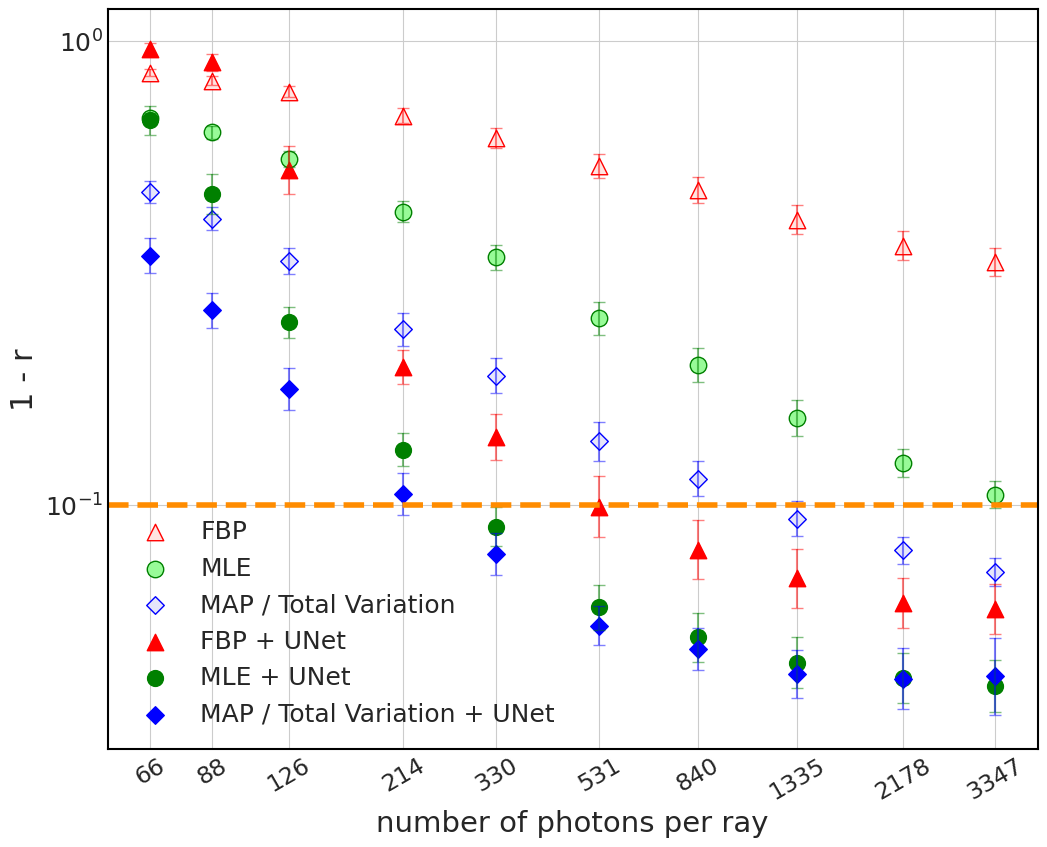

In [8]:
plt.rcParams['figure.figsize'] = [10*1.2, 8*1.2]
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Mishafi"
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'light'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"]  = 1.5

# plt.rcParams.update({
#     'font.family': 'serif',
#     'font.serif': 'Times New Roman',  # 'Nimbus Roman No9 L',
# })

markersize = 140

fig, ax = plt.subplots()

alpha = 0.5

plt.scatter(dis_final, FBP_pcc, marker='^', facecolors='mistyrose', color='red', s=markersize, label="FBP")
plt.errorbar(dis_final, FBP_pcc, yerr=[FBP_std_low, FBP_std_high], fmt='none', color="red", alpha=alpha, capsize=4)

plt.scatter(dis_final, iterative_sparse_recon_pcc, marker='o', facecolors='palegreen', s=markersize, color='green', label="MLE")
plt.errorbar(dis_final, iterative_sparse_recon_pcc, yerr=[iterative_sparse_recon_std_low, iterative_sparse_recon_std_high], fmt='none', color="green", alpha=alpha, capsize=4)

plt.scatter(dis_final, iterative_sparse_TV_recon_pcc, marker='D', facecolors='lavender', s=markersize-60, color='blue', label="MAP / Total Variation")
plt.errorbar(dis_final, iterative_sparse_TV_recon_pcc, yerr=[iterative_sparse_TV_recon_std_low, iterative_sparse_TV_recon_std_high], fmt='none', color="blue", alpha=alpha, capsize=4)

plt.scatter(dis_final, FBP_UNet0_pcc, marker='^', s=markersize, color='r', label="FBP + UNet")
plt.errorbar(dis_final, FBP_UNet0_pcc, yerr=[FBP_UNet0_std_low, FBP_UNet0_std_high], fmt='none', color="r", alpha=alpha, capsize=4)

plt.scatter(dis_final, iter30_pcc, marker='o', s=markersize-10, color='green', label="MLE + UNet")
plt.errorbar(dis_final, iter30_pcc, yerr=[iter30_std_low, iter30_std_high], fmt='none', color="green", alpha=alpha, capsize=4)

plt.scatter(dis_final, iter30_TV_pcc, marker='D', s=markersize-60, color='blue', label="MAP / Total Variation + UNet")
plt.errorbar(dis_final, iter30_TV_pcc, yerr=[iter30_TV_std_low, iter30_TV_std_high], fmt='none', color="blue", alpha=alpha, capsize=4)

plt.axhline(y=1/10, color='darkorange', linestyle='--', lw=4)
plt.legend(fontsize=18, loc='lower left')
plt.xlabel("number of photons per ray", fontsize=21)
plt.ylabel("1 - r", fontsize=22)
plt.xticks(dis_final, [66, 88, 126, 214, 330, 531, 840, 1335, 2178, 3347], rotation=30, fontsize=17)
plt.yticks(fontsize=18)
#plt.ticklabel_format(axis='y', scilimits=(-1, 1), style='sci')
ax.yaxis.offsetText.set_fontsize(20)
plt.yscale('log')
plt.show()

/state/partition1/slurm_tmp/21190064.0.0/ipykernel_4895/1468723197.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


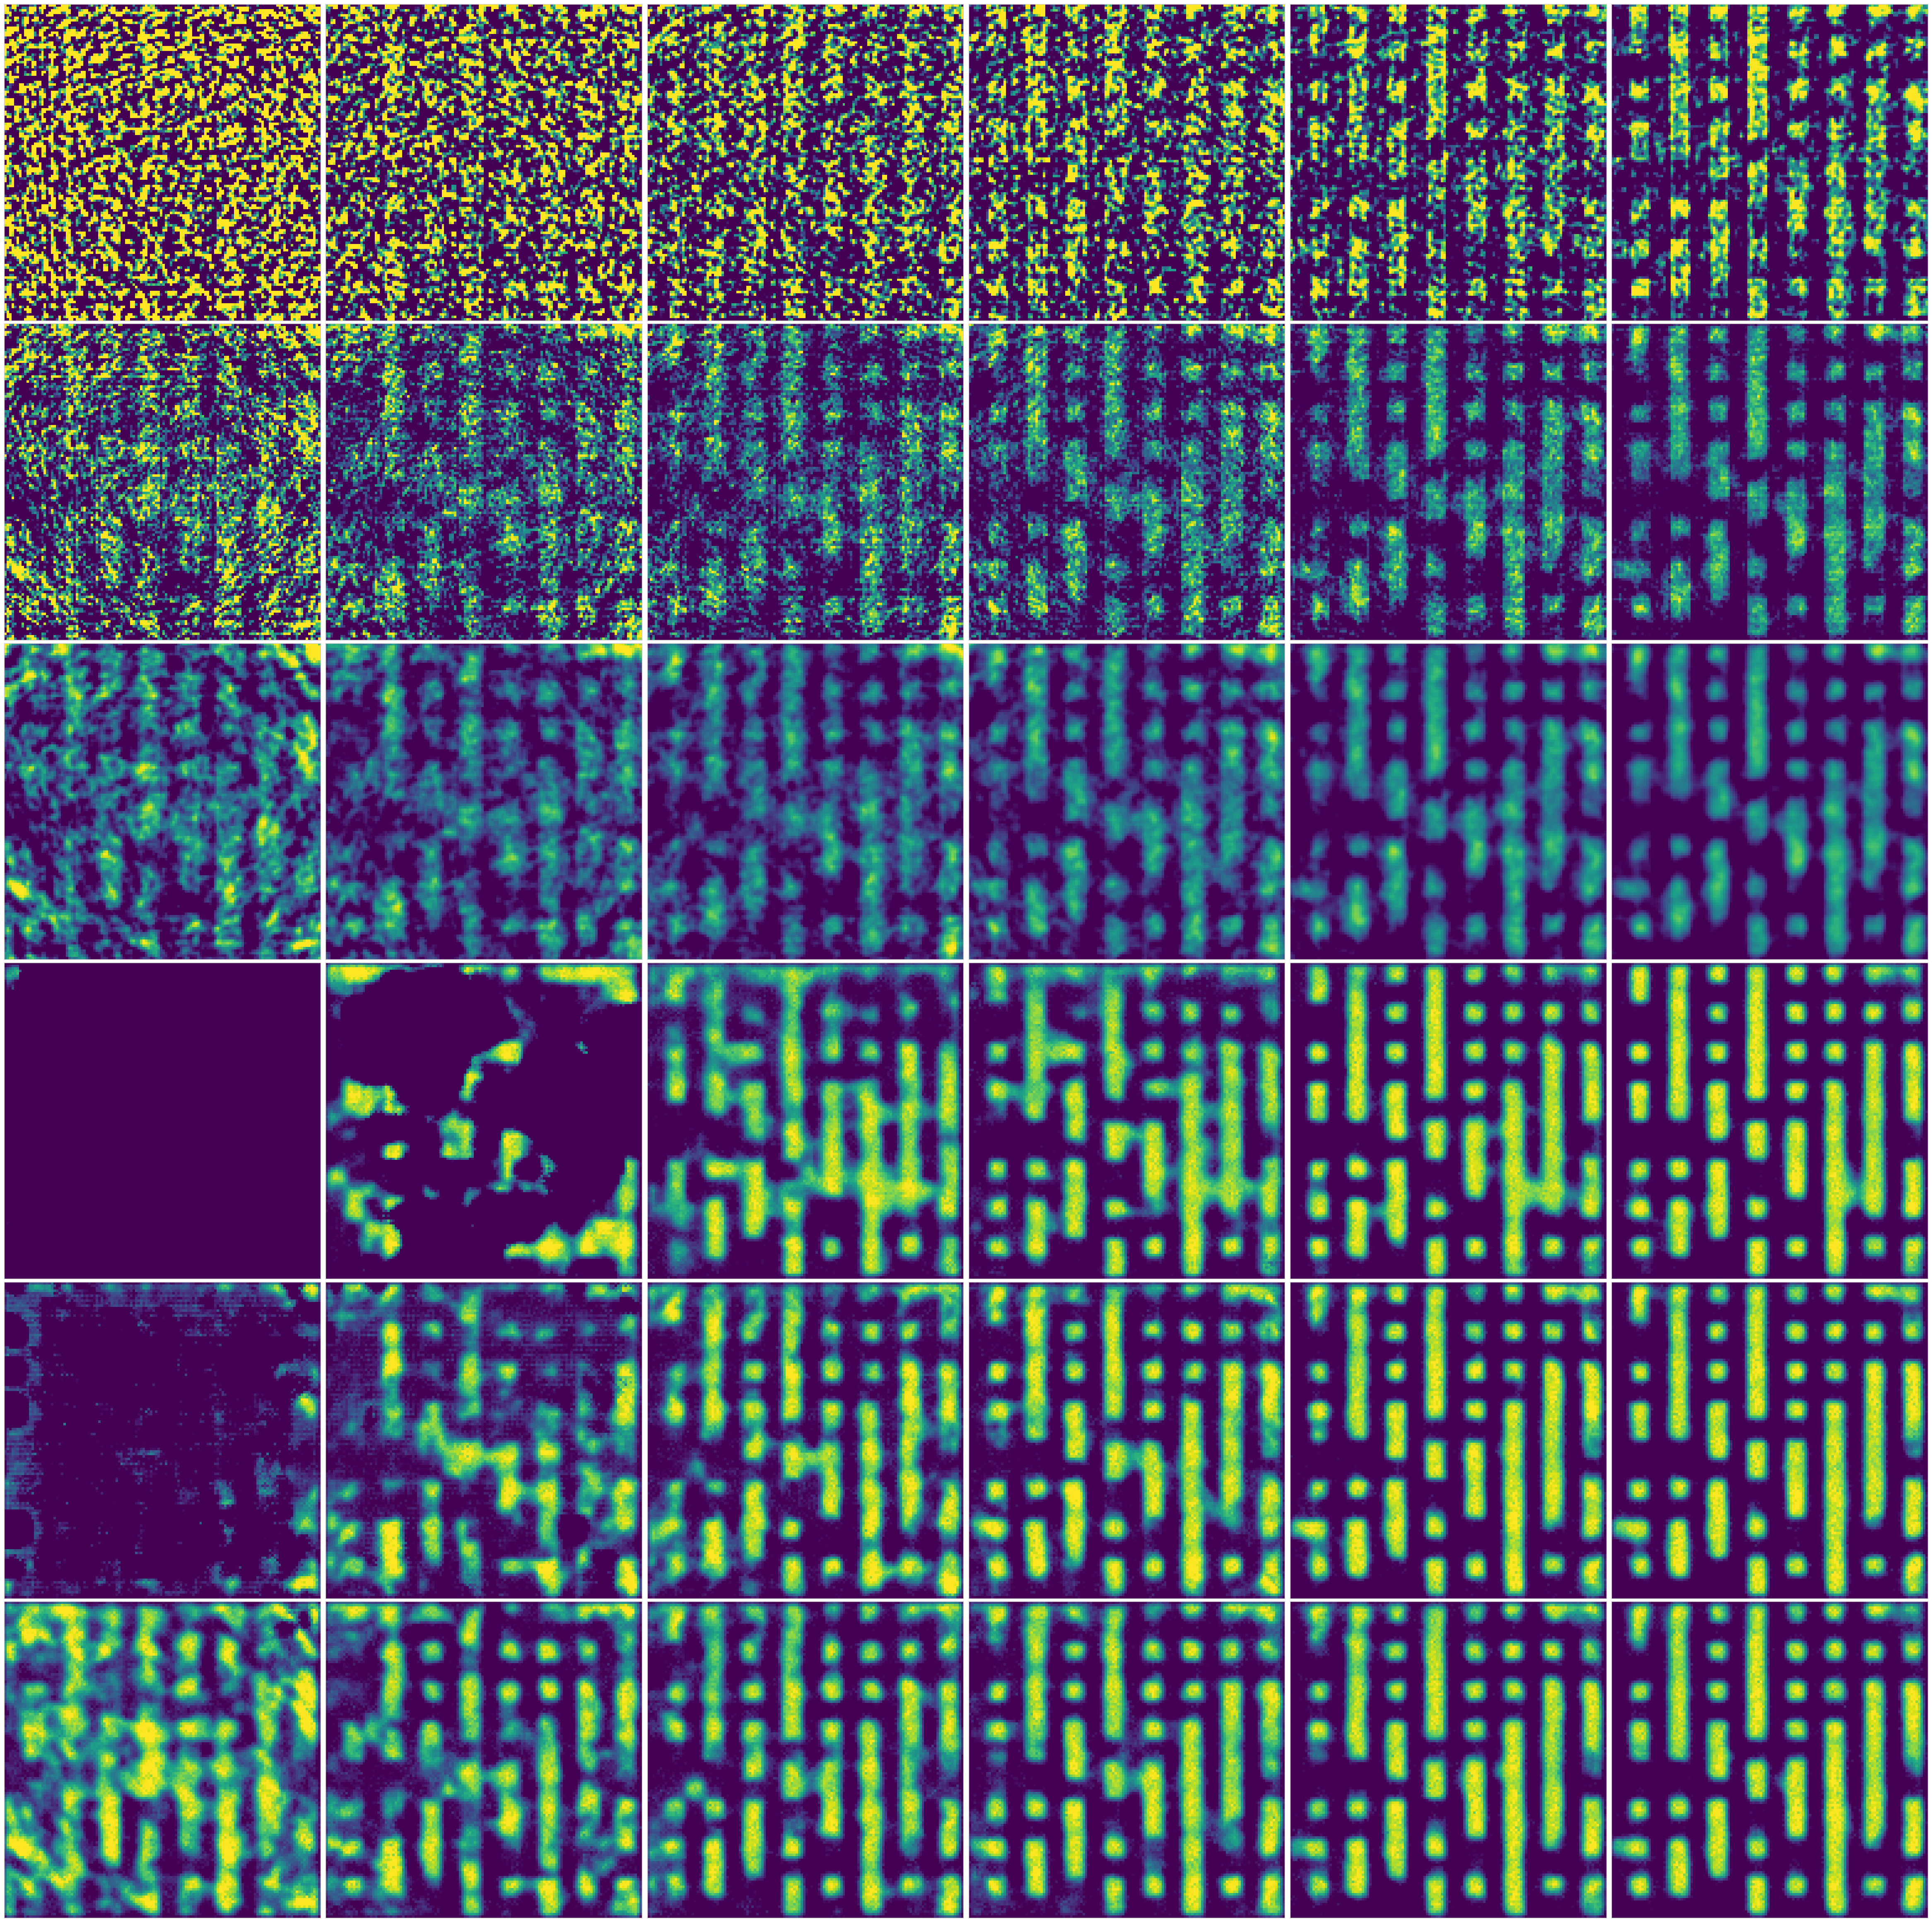

In [9]:
high = 0.125
low = 0.03

obj_idx = 33

offset1 = 2 - 2
offset2 = 4 - 2
offset2_ = 5 - 2
offset3 = 6 - 2
offset4 = 8 - 2
offset5 = 10 - 2

x = 6
y = 6

plt.style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = [60, 60]
fig = plt.figure()
fig.subplots_adjust(hspace=.01, wspace=.01)

for i in range(x*y):
     
    ax = fig.add_subplot(y, x, i +1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    if i//x == 5 :
        if i % x == 0:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(iter30_TV[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)
    
    if i//x == 4 :
        if i % x == 0:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(iter30[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)
    if i//x == 3 :
        if i % x == 0:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(FBP_UNet0[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)
    if i//x == 2 :
        if i % x == 0:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)
    if i//x == 1 :
        if i % x == 0:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(iterative_sparse_recon[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)
    if i//x == 0 :
        if i % x == 0:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset1], 3), cmap='viridis')
        elif i % x == 1:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset2], 3), cmap='viridis')
        elif i % x == 2:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset2_], 3), cmap='viridis')
        elif i % x == 3:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset3], 3), cmap='viridis')
        elif i % x == 4:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset4], 3), cmap='viridis')
        elif i % x == 5:
            plt.imshow(np.rot90(FBP[obj_idx + 40*offset5], 3), cmap='viridis')
        plt.clim(low, high)

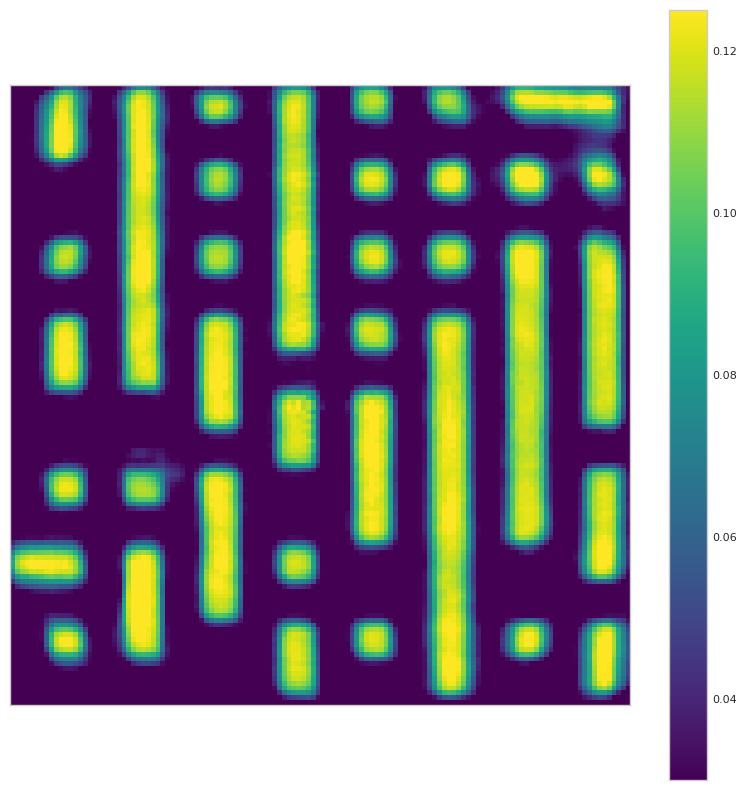

In [10]:
for obj_idx in [-1]:

    plt.rcParams['figure.figsize'] = [10, 10]
    fig = plt.figure()
    fig.subplots_adjust(hspace=.01, wspace=.01)

    for i in range(1):

        ax = fig.add_subplot(1, 1, i +1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if i == 0:
            plt.imshow(np.rot90(full_angle_recon[obj_idx], 3), cmap='viridis')
        elif i == 1:
            plt.imshow(np.rot90(iterative_sparse_TV_recon[obj_idx], 3), cmap='viridis')
        elif i == 2:
            plt.imshow(np.rot90(iter50_TV[obj_idx], 3), cmap='viridis')
        plt.clim(low, high)
        plt.colorbar()